# **Visualization Notebook**

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ryan_\\VS-code-projects\\CreditCardChurn\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ryan_\\VS-code-projects\\CreditCardChurn'

# H1: Engagement

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

df = pd.read_csv("dataFiles\cleanData\cleaned_credit_card_churn_data.csv")
df.head(2)
df.tail(2)

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\ryan_\AppData\Local\Temp\ipykernel_9828\3208953025.py:7: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv("dataFiles\cleanData\cleaned_credit_card_churn_data.csv")


,Clientnum,AttritionFlag,CustomerAge,Gender,DependentCount,EducationLevel,MaritalStatus,IncomeCategory,CardCategory,MonthsOnBook,...,ChurnFlag,GenderEnc,IncomeCatEnc,EducationLevelEnc,MaritalStatusEnc,CardCategoryEnc,AvgTransaction_Value,UtilizationBand,AvgTransactionValue,Inactive3plusFlag
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,1,1,1.0,2,3,0,135.403226,0,135.403226,1
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,...,1,0,0.0,2,1,3,168.754098,0–0.25,168.754098,0


---

## Hypothesis 1 — Engagement and Inactivity

### Business Question
Are customers with lower engagement (higher inactivity and fewer product relationships) more likely to churn?

### Hypothesis
Customers with **higher inactivity** (Months_Inactive_12_mon) and **lower relationship count**
(Total_Relationship_Count) are more likely to churn.

### Measures Used
- **Churn outcome:** `ChurnFlag` (1 = churned, 0 = existing)
- **Inactivity:** `MonthsInactive12Mon`
- **Engagement proxy:** `TotalRelationshipCount`

### Analytical Approach
I compare churn rates and distributions between churned vs existing customers:
1. Compare inactivity distributions by churn status (boxplot + summary statistics).
2. Compare churn rate across different relationship counts (bar chart + rate table).


In [5]:
#Sanity check to confirm columns of interest are present
required_cols = ["ChurnFlag", "AttritionFlag", "MonthsInactive12Mon", "TotalRelationshipCount"]
missing = [c for c in required_cols if c not in df.columns] #changed to not in to lessen non critical outputs on notebook
print("Missing columns:", missing)


Missing columns: []


# Evidence 1: Inactivity vs churn (Chart + stats)

In [6]:
inactivity_summary = (
    df.groupby("AttritionFlag")["MonthsInactive12Mon"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
inactivity_summary


,count,mean,median,min,max
AttritionFlag,,,,,
Attrited Customer,1627,2.69,3.0,0,6
Existing Customer,8500,2.27,2.0,0,6


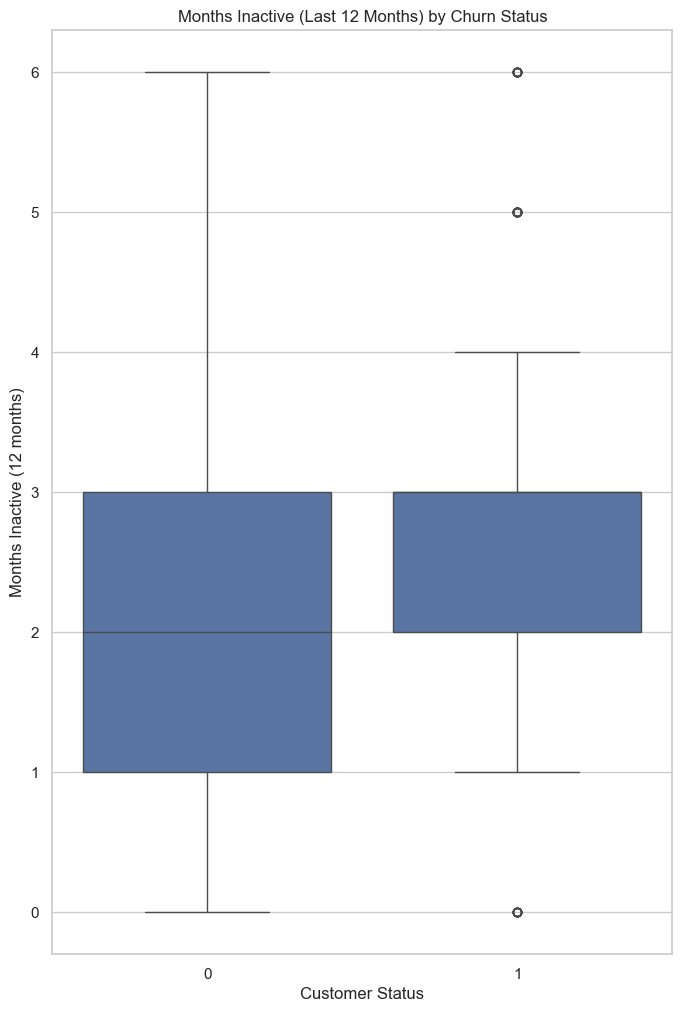

In [10]:
plt.figure(figsize=(8, 12))
sns.boxplot(data=df, x="ChurnFlag", y="MonthsInactive12Mon")
plt.title("Months Inactive (Last 12 Months) by Churn Status")
plt.xlabel("Customer Status")
plt.ylabel("Months Inactive (12 months)")
plt.show()


---

# Key Finding

### Evidence A — Inactivity vs Churn

**What I expected:**  
Customers who churn would exhibit higher levels of inactivity
compared to customers who remain with the bank.

**What the data shows:**  
- Churned customers have a higher average number of inactive months
  (mean = 2.69) compared to existing customers (mean = 2.27).
- The median inactivity for churned customers is **3 months**,
  compared to **2 months** for existing customers.
- While both groups share the same minimum and maximum inactivity values,
  the distribution for churned customers is shifted toward higher inactivity.

**Interpretation:**  
Higher customer inactivity is associated with an increased likelihood of churn,
supporting the view that disengagement is an early warning signal for attrition.


# Evidence 2: Relationship count vs churn (rates + chart)

In [12]:
churn_by_relationship = (
    df.groupby("TotalRelationshipCount")["ChurnFlag"]
      .agg(churn_rate="mean", customers="count")
      .reset_index()
)
churn_by_relationship["churnratepct"] = (churn_by_relationship["churn_rate"] * 100).round(2)
churn_by_relationship.sort_values("TotalRelationshipCount")


,TotalRelationshipCount,churn_rate,customers,churnratepct
0,1,0.256044,910,25.60
1,2,0.278359,1243,27.84
2,3,0.173536,2305,17.35
3,4,0.117678,1912,11.77
4,5,0.120042,1891,12.00
5,6,0.105038,1866,10.50


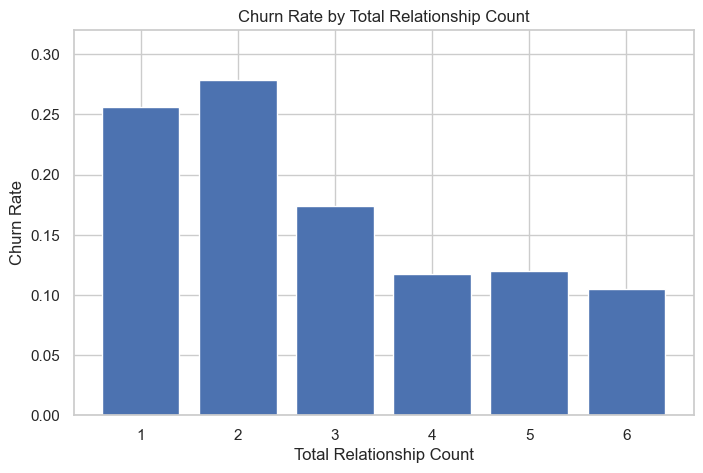

In [13]:
churn_rate_series = (
    df.groupby("TotalRelationshipCount")["ChurnFlag"]
      .mean()
      .sort_index()
)

plt.figure(figsize=(8, 5))
plt.bar(churn_rate_series.index.astype(str), churn_rate_series.values)
plt.title("Churn Rate by Total Relationship Count")
plt.xlabel("Total Relationship Count")
plt.ylabel("Churn Rate")
plt.ylim(0, churn_rate_series.max() * 1.15)
plt.show()


### Evidence B — Relationship Count vs Churn Rate

**What I expected:**  
Customers with fewer product relationships would exhibit higher churn rates,
while customers with more relationships would show greater retention.

**What the data shows:**  
- Customers with **1–2 relationships** show the highest churn rates
  (25.6% and 27.8% respectively).
- A substantial reduction in churn is observed once customers hold **3 or more relationships**.
- Customers with **6 relationships** exhibit the lowest churn rate (10.5%).
- Overall, churn rates decline as the total relationship count increases.

**Interpretation:**  
Higher product engagement, measured by total relationship count,
is associated with lower churn risk.
Customers with multiple relationships appear more embedded in the bank’s ecosystem,
making them less likely to leave.


### Conclusion — Hypothesis 1

The results support Hypothesis 1.
Customers who churn tend to be less engaged, showing both higher inactivity
and fewer product relationships.

While churn among customers with two relationships is slightly higher than those with one,
the overall trend demonstrates a clear reduction in churn
as relationship count increases beyond two.

### Business Implications
- Customers with **1–2 relationships** represent a high-risk churn segment
  and should be prioritised for early engagement initiatives.
- Encouraging customers to adopt additional products
  may strengthen retention by increasing overall engagement.
- Relationship count can be used as a simple, interpretable
  early-warning indicator for churn risk.

### Limitations
This analysis is descriptive and does not establish causality.
Additional behavioural and external factors not present in the dataset
may also influence churn outcomes.


---

# Hypothesis 2 — Tenure & Churn

# Ending words 